Here we define the way we'll be training the large (100 site) MHS model

In [1]:
import tensorflow as tf 
import tensorflow_addons as tfa
import numpy as np 
import matplotlib.pyplot as plt 
import itertools
import copy
from typing import *
from TransformerWF import *
from entanglement_tools import *
import cirq
from numpy import linalg as LA
from scramble_spins import scramble
import json

C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def inverse_d_squared(i, j, N):
    """
    d in equation 8
    https://arxiv.org/pdf/1701.04844.pdf
    """
    mask = 1*((i-j)!=0)
    
    argument = np.pi*(j-i)/N
    
    d_value = N*np.abs(np.sin(argument))/np.pi
    
    #print(np.max(d_value))
    
    outputs = mask / (d_value**2 + (1-mask))
    
    return outputs

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


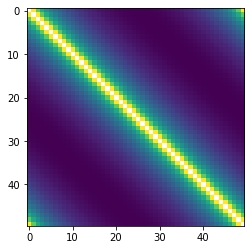

In [4]:
plt.imshow(np.log(inverse_d_squared(np.arange(50)[:, None], np.arange(50)[None, :], N=50)), interpolation=None)

In [5]:
def give_flip_matrix(i, config_length):
    """
    give a matrix with shape (length-1, length) that has
    the ith element flipped, along with every other element
    """
    flip_matrix = np.array(
        [
            [-1 if k in (i, j) else 1 for k in range(config_length)] 
            for j in range(config_length) if j!=i
        ]
    )
    return flip_matrix

In [6]:
def give_all_flips_i(
    configuration: np.array,
    i: int,
):
    """
    given states of shape (batch_size, length), return the states with 
    the ith, jth spins flipped. 
    The output should be of shape 
    (batch_size, length-1, length)
    """
    batch_size = configuration.shape[0]
    config_length = configuration.shape[1]
    
    flip_matrix = give_flip_matrix(i, config_length)
    # note this has shape (length-1, length)
    
    flipped_states = np.einsum("bl,hl->bhl", 2*configuration - 1, flip_matrix)
    flipped_states = ((flipped_states+1)/2).astype(np.int32)
    
    return flipped_states

In [7]:
def mhs_E_loc(configuration, decoder):
    """
    configuration should have shape
    
    config_length
    
    we need to consider the same state, and the state 
    with each site flipped.
    
    return the real and imaginary parts of E_loc
    
    if scramble, then un-scramble states before evaluating their ELOC values
    """
    batch_size = configuration.shape[0]
    config_length = configuration.shape[1]
    
    """
    evaluate wavefunctions
    """
    log_probs, total_phases = decoder.evaluate_state(
        configuration,
    )
    
    """
    first we include z contributions
    """
    inverse_d_squared_array = inverse_d_squared(
        np.arange(config_length)[:, None], 
        np.arange(config_length)[None, :], 
        N=config_length
    )
    
    # divide by 2 for double counting   
    d2 = np.einsum(
        "ij,bi,bj->b", 
        inverse_d_squared_array, 
        1-2*configuration, 
        1-2*configuration
    )/2
    
    E_loc_real_part = d2
    E_loc_imag_part = 0
    
    """
    Now include off-diagonal contributions
    
    To be safe, and allow for large system sizes without
    overwhelming memory, Im going to go through this iteratively
    """
    for i in range(config_length):
        """
        First compute all flipped states with i and
        a different index flipped.
        
        Then evaluate the wavefunction for these states
        """
        flipped_states = give_all_flips_i(
            configuration=configuration,
            i=i,
        )
        
        reshaped_flipped_states = np.reshape(
            flipped_states, 
            (-1, config_length)
        )
        
        flipped_log_prob_batches, flipped_total_phases_batches = [], []
        
        flipped_batch_size = reshaped_flipped_states.shape[0]
        
        for batch_idx in range(int(reshaped_flipped_states.shape[0]//flipped_batch_size)+1):
            
            flipped_log_probs, flipped_total_phases = decoder.evaluate_state(
                reshaped_flipped_states[batch_idx*flipped_batch_size: (batch_idx+1)*flipped_batch_size],
            )
            
            flipped_total_phases_batches.append(flipped_total_phases.numpy())
            flipped_log_prob_batches.append(flipped_log_probs.numpy())
        
        flipped_total_phases = tf.concat(flipped_total_phases_batches, 0)
        flipped_log_probs = tf.concat(flipped_log_prob_batches, 0)
        
        flipped_total_phases = tf.reshape(flipped_total_phases, (batch_size, -1))
        flipped_log_probs = tf.reshape(flipped_log_probs, (batch_size, -1))
        
        assert flipped_total_phases.shape == (batch_size, config_length-1)
        assert flipped_log_probs.shape == (batch_size, config_length-1)
        
        """
        The coefficient here is (s_i*s_j - 1)
        multiply each flipped contribution by this coefficient
        """
        
        spins = 1-2*configuration
        
        sj_values = np.hstack(
            [spins[:, :i], spins[:, i+1:]]
        )
        si_values = spins[:, i]
        
        d_values = np.array(
            [
                inverse_d_squared(i, j, N=config_length) 
                for j in range(config_length) if j!=i
            ]
        )
        
        current_coefficients = (si_values[:, None] * sj_values - 1)*d_values[None, :]
        
        ratio_mags = tf.math.exp(
            (1/2)*(flipped_log_probs - log_probs[..., None])
        )

        ratio_real_part = ratio_mags*np.cos(-total_phases[..., None] + flipped_total_phases)
        ratio_imag_part = ratio_mags*np.sin(-total_phases[..., None] + flipped_total_phases)
        
        assert ratio_real_part.shape == (batch_size, config_length-1)
        assert ratio_imag_part.shape == (batch_size, config_length-1)
        
        # again dividing by 2 to avoid double counting 
        E_loc_real_part += np.einsum(
            "bj,bj->b",
            ratio_real_part,
            current_coefficients,
        )/2
        E_loc_imag_part += np.einsum(
            "bj,bj->b",
            ratio_imag_part,
            current_coefficients,
        )/2
    
    assert E_loc_real_part.shape[0]==batch_size
    assert E_loc_imag_part.shape[0]==batch_size
    
    return E_loc_real_part, E_loc_imag_part

In [8]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=400, final_step = 1000, minimum_step_size = 10**-8):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.final_step = final_step
        self.minimum_step_size = minimum_step_size
        
        self.initial_slope = tf.math.rsqrt(self.d_model*self.warmup_steps)/self.warmup_steps
        
        self.c = tf.math.rsqrt(self.d_model*self.warmup_steps)
        
        self.rate = -(final_step - warmup_steps)/np.log(minimum_step_size)
        
    def __call__(self, step):
        
        if step<self.warmup_steps:
            return self.initial_slope*step
        
        return self.c*np.exp(-(step-self.warmup_steps)/self.rate)

# sanity checking

_Any_ change to $E_{loc}$ should be followed by a check to ensure that the resulting trained state matches the GS on a small system size. 

In [9]:
"""
Do we want to check this all works on a small system size
"""
check_eloc = False

if check_eloc:
    
    check_indices = [0]+[int(index) for index in np.logspace(0, 3, 20)]
    
    embedding_dimension=15
    
    test_learning_rate = CustomSchedule(
        d_model=embedding_dimension, 
        warmup_steps=250, 
        final_step = 1000, 
        minimum_step_size = 0.001,
    )

    test_optimizer = tf.keras.optimizers.Adam(
        test_learning_rate, 
        beta_1=0.9, 
        beta_2=0.98, 
        epsilon=1e-9,
    )
    
    test_sequence_length=10+1

    test_decoder=TransformerDecoder( 
        num_heads=2, 
        key_dim=embedding_dimension, 
        value_dim=embedding_dimension, 
        embedding_dim=embedding_dimension, 
        dictionary_size=2,
        decoding_reps=2, 
        width=15, 
        depth=2,
        name=None,
        sequence_length=test_sequence_length,
        dropout=0,
        attention_dropout=0,
        final_temperature=1,
    )
    
    initial_training_reps = 1000
    Ns=50
    
    test_real_energies = []
    test_imag_energies = []

    for current_rep in range(initial_training_reps):

        derivatives, (e_real, e_imag) = test_decoder.evaluate_gradients(Ns, mhs_E_loc, reps=1)

        test_optimizer.apply_gradients(zip(derivatives, test_decoder.trainable_weights))

        test_real_energies.append(e_real)
        test_imag_energies.append(e_imag)
        
        if current_rep in check_indices and current_rep>0:
            position = check_indices.index(current_rep)
            prev = check_indices[position-1]
            print(f"step {prev} to {current_rep} mean:", np.mean(test_real_energies[prev:current_rep]))
    
    """
    compute overlap with exact ground state
    """
    
    print("\n comparing to exact diagonalization \n")
    
    mhs_ham = cirq.PauliSum()

    for i in range(10):
        for j in range(10):
            if i!=j:
                coefficient = inverse_d_squared(i, j, N=10)

                sub_sum = cirq.PauliSum()

                sub_sum += cirq.Z(cirq.LineQubit(i))*cirq.Z(cirq.LineQubit(j))
                sub_sum -= cirq.X(cirq.LineQubit(i))*cirq.X(cirq.LineQubit(j))
                sub_sum -= cirq.Y(cirq.LineQubit(i))*cirq.Y(cirq.LineQubit(j))

                mhs_ham += sub_sum*coefficient/2
    
    ham_mat = mhs_ham.matrix()

    ws, vs = LA.eigh(ham_mat)

    gs = get_explicit_transformer_state(
        test_decoder,
        qubit_num=10,
        assert_real=False,
    )

    overlap = np.abs(np.sum(gs*vs[:, 0]))
    
    print(f"overlap: {overlap}")
    
    plt.plot(np.abs(gs))
    plt.title("Transformer Ground State")
    plt.show()
    
    plt.plot(np.abs(vs[:, 0]))
    plt.title("ED Ground State")
    plt.show()
    
    # free up any space this may have taken
    del test_decoder

# training the model

In [10]:
embedding_dimension=15
sequence_length=100+1

params = {
    "num_heads": 2, 
    "key_dim": embedding_dimension, 
    "value_dim": embedding_dimension, 
    "embedding_dim": embedding_dimension, 
    "dictionary_size": 2,
    "decoding_reps": 2, 
    "width": None, 
    "depth": 2,
    "sequence_length": sequence_length,
}

In [11]:
"""
We choose a random seed for this initialization
"""
seed = 1

In [12]:
name = f"length_100_mhs_seed_{seed}"

with open(f"params_{name}.json", "w") as outfile:
    json.dump(params, outfile)

In [13]:
tf.random.set_seed(seed=seed)

decoder=TransformerDecoder(
    **params
)

In [14]:
print("number of params: ", np.sum([np.prod(array.shape) for array in decoder.trainable_weights]))

number of params:  3922


In [15]:
learning_rate = CustomSchedule(
    d_model=embedding_dimension, 
    warmup_steps=400, 
    final_step = 2000, 
    minimum_step_size = 0.0001,
)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

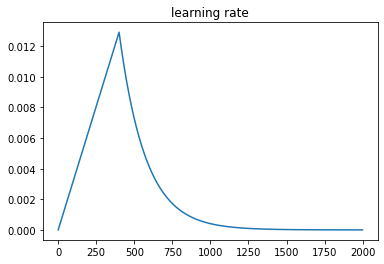

In [16]:
plt.plot([learning_rate(float(n)) for n in range(2000)])
plt.title("learning rate")
plt.show()

In [17]:
real_energies = []
imag_energies = []

In [18]:
Ns=50

for idx in range(learning_rate.final_step):
    
    derivatives, (e_real, e_imag) = decoder.evaluate_gradients(Ns, mhs_E_loc)
    
    optimizer.apply_gradients(zip(derivatives, decoder.trainable_weights))
    
    real_energies.append(e_real)
    imag_energies.append(e_imag)
    
    if idx%5==0 and idx>0:
        print(f"step {idx-5} to {idx} mean:", np.mean(real_energies[-5:]))
    
    if idx%50==0:
        np.save(f"{name}.npy", np.array(list(zip(real_energies, imag_energies)), dtype=np.complex128))
        decoder.save_weights(name)

np.save(f"{name}.npy", np.array(list(zip(real_energies, imag_energies)), dtype=np.complex128))
decoder.save_weights(name)

step 0 to 5 mean: -121.45336046719487
step 5 to 10 mean: -132.9943274615668
step 10 to 15 mean: -143.99242277682615
step 15 to 20 mean: -153.0658462176292
step 20 to 25 mean: -150.80484911283412
step 25 to 30 mean: -158.88647982638693
step 30 to 35 mean: -162.2458763017878
step 35 to 40 mean: -161.0330405270321
step 40 to 45 mean: -159.60709452093255
step 45 to 50 mean: -163.30800367755762
step 50 to 55 mean: -168.80260514120766
step 55 to 60 mean: -168.51099566443702
step 60 to 65 mean: -168.33662031350883
step 65 to 70 mean: -168.76771355775406
step 70 to 75 mean: -171.97373584296088
step 75 to 80 mean: -172.75591165133318
step 80 to 85 mean: -177.77918049959365
step 85 to 90 mean: -177.98346374509444
step 90 to 95 mean: -185.42533553681017
step 95 to 100 mean: -190.51193494557697
step 100 to 105 mean: -194.72297733237946
step 105 to 110 mean: -196.43804697888157
step 110 to 115 mean: -198.0345872022869
step 115 to 120 mean: -199.04415737952476
step 120 to 125 mean: -198.064668739025

step 990 to 995 mean: -211.05332331238506
step 995 to 1000 mean: -211.2547097306724
step 1000 to 1005 mean: -211.242973022359
step 1005 to 1010 mean: -211.22317057099357
step 1010 to 1015 mean: -211.09116008028167
step 1015 to 1020 mean: -211.1702388075164
step 1020 to 1025 mean: -211.06348614747608
step 1025 to 1030 mean: -211.01747689474936
step 1030 to 1035 mean: -211.0549956519123
step 1035 to 1040 mean: -211.54626817965487
step 1040 to 1045 mean: -210.9841663821931
step 1045 to 1050 mean: -211.18143004191415
step 1050 to 1055 mean: -211.358686936276
step 1055 to 1060 mean: -211.27401899085717
step 1060 to 1065 mean: -211.07527237972945
step 1065 to 1070 mean: -211.3795798062863
step 1070 to 1075 mean: -211.05139498873078
step 1075 to 1080 mean: -211.33118984746883
step 1080 to 1085 mean: -211.31868705635625
step 1085 to 1090 mean: -211.43759027729948
step 1090 to 1095 mean: -211.0681997386934
step 1095 to 1100 mean: -211.13051300781407
step 1100 to 1105 mean: -211.30193231511075
s

step 1930 to 1935 mean: -211.1883572089433
step 1935 to 1940 mean: -211.20283169154905
step 1940 to 1945 mean: -211.5094960408273
step 1945 to 1950 mean: -211.27506566998818
step 1950 to 1955 mean: -211.38628519737395
step 1955 to 1960 mean: -211.2972131474251
step 1960 to 1965 mean: -211.07540266413602
step 1965 to 1970 mean: -211.38878984091951
step 1970 to 1975 mean: -211.5824651235103
step 1975 to 1980 mean: -211.33536335356817
step 1980 to 1985 mean: -211.05310142936597
step 1985 to 1990 mean: -211.3715421850803
step 1990 to 1995 mean: -211.2382400441539


In [19]:
energy = []
for rep in range(10):
    initial_states = np.zeros((50, 1))
    
    samples, log_probs, phases = decoder.autoregressive_sampling(
        initial_states
    )
    
    er, ei = mhs_E_loc(samples, decoder)
    
    energy.append(er)

In [20]:
np.mean(energy), np.std(energy, ddof=1)

(-211.2663670976272, 2.4852636457943666)

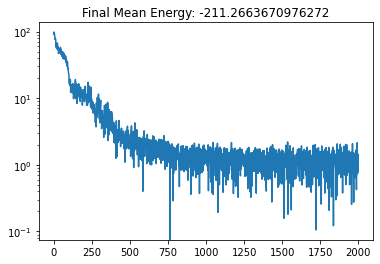

In [21]:
plt.plot(np.array(real_energies)-np.min(np.array(real_energies)))
plt.title(f"Final Mean Energy: {np.mean(energy)}")
plt.yscale('log')